# SENTIMENT ANALYSIS
**author:** Sam Luu

In [1]:
# Install required packages (Uncomment if running in a new environment)
!pip install -q torch torchvision torchaudio transformers datasets pandas scikit-learn tqdm seaborn matplotlib accelerate

import os
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup complete. Using device: {device}")

c:\Users\luuch\anaconda3\envs\sentiment_analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Setup complete. Using device: cpu


In [2]:
# --- 1. DATA ACQUISITION ---

csv_file = "amazon_polarity_sample.csv"
SAMPLE_SIZE = 5000  # Number of samples to use (Adjust based on your RAM)

if os.path.exists(csv_file):
    print(f"Loading existing dataset from '{csv_file}'...")
    df = pd.read_csv(csv_file)
else:
    print("Downloading dataset from Hugging Face...")
    # Load a slice of the dataset to avoid memory issues
    dataset = load_dataset("amazon_polarity", split=f"train[:{SAMPLE_SIZE}]")
    df = dataset.to_pandas()
    
    # Preprocessing: Combine Title and Content
    print("Preprocessing data...")
    df['full_text'] = df['title'].fillna('') + ". " + df['content'].fillna('')
    
    # Keep only necessary columns
    df = df[['full_text', 'label']]
    
    # Save for future use
    df.to_csv(csv_file, index=False)
    print(f"Dataset saved to '{csv_file}'")

# Display sample
print("\n--- SAMPLE DATA ---")
pd.set_option('display.max_colwidth', 100)
display(df.head())

# Check class distribution
print("\n--- CLASS DISTRIBUTION ---")
print(df['label'].value_counts())

Loading existing dataset from 'amazon_polarity_sample.csv'...

--- SAMPLE DATA ---


,full_text,label,label_name
0,Stuning even for the non-gamer. This sound track was beautiful! It paints the senery in your min...,1,Positive
1,The best soundtrack ever to anything.. I'm reading a lot of reviews saying that this is the best...,1,Positive
2,"Amazing!. This soundtrack is my favorite music of all time, hands down. The intense sadness of ""...",1,Positive
3,Excellent Soundtrack. I truly like this soundtrack and I enjoy video game music. I have played t...,1,Positive
4,"Remember, Pull Your Jaw Off The Floor After Hearing it. If you've played the game, you know how ...",1,Positive



--- CLASS DISTRIBUTION ---
label
0    538
1    462
Name: count, dtype: int64


In [3]:
# --- 2. TRAIN / VALIDATION SPLIT ---

# Split data: 80% Train, 20% Validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Convert back to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Clean up index columns generated by pandas conversion
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset = val_dataset.remove_columns(["__index_level_0__"])

Training samples: 800
Validation samples: 200


In [4]:
# --- 3. TOKENIZATION ---

# Using pre-trained sentiment model (already fine-tuned for sentiment!)
MODEL_CKPT = "nlptown/bert-base-multilingual-uncased-sentiment"

print(f"Loading tokenizer: {MODEL_CKPT}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
print("✅ Tokenizer loaded successfully")

def tokenize_function(examples):
    return tokenizer(
        examples["full_text"], 
        truncation=True, 
        max_length=128
    )

print("Tokenizing datasets...")
# Map the function over the dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

# Remove raw text columns (Model only needs input_ids, attention_mask, labels)
cols_to_remove = ["full_text"]
tokenized_train = tokenized_train.remove_columns(cols_to_remove)
tokenized_val = tokenized_val.remove_columns(cols_to_remove)

# Rename 'label' to 'labels' (Required by HF Trainer)
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")

# Set format for PyTorch
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")

print("✅ Tokenization complete.")

Loading tokenizer: nlptown/bert-base-multilingual-uncased-sentiment
✅ Tokenizer loaded successfully
Tokenizing datasets...
✅ Tokenizer loaded successfully
Tokenizing datasets...


Map: 100%|██████████| 200/200 [00:00<00:00, 9927.35 examples/s]

✅ Tokenization complete.


In [5]:
# --- 4. MODEL & METRICS ---

# Load Pre-trained Sentiment Model
# Note: This model has 5 labels (1-5 stars), but we'll fine-tune for binary (Neg/Pos)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=2, ignore_mismatched_sizes=True)
model.to(device)
print(f"✅ Model loaded: {MODEL_CKPT}")

# Define Metrics Function (Trainer only calculates Loss by default)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Data Collator (Handles dynamic padding for batching)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: nlptown/bert-base-multilingual-uncased-sentiment


In [6]:
# --- 5. TRAINING ---

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    learning_rate=2e-5,              # Standard learning rate for BERT
    weight_decay=0.01,               # Strength of weight decay
    eval_strategy="epoch",           # Evaluate every epoch (renamed from evaluation_strategy)
    save_strategy="epoch",           # Save checkpoint every epoch
    load_best_model_at_end=True,     # Load the best model when finished
    metric_for_best_model="accuracy",
    report_to="none",                # Disable WandB/Tensorboard for simple notebooks
    logging_dir='./logs',            # Directory for storing logs
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start Training
print(">>> Starting training...")
trainer.train()

>>> Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.167731,0.940000,0.934066,0.944444,0.923913
2,No log,0.258512,0.915000,0.901734,0.962963,0.847826
3,No log,0.200995,0.950000,0.945055,0.955556,0.934783


TrainOutput(global_step=150, training_loss=0.15562026977539062, metrics={'train_runtime': 926.6663, 'train_samples_per_second': 2.59, 'train_steps_per_second': 0.162, 'total_flos': 157866633216000.0, 'train_loss': 0.15562026977539062, 'epoch': 3.0})

Evaluating on Validation Set...


Validation Accuracy: 0.9500


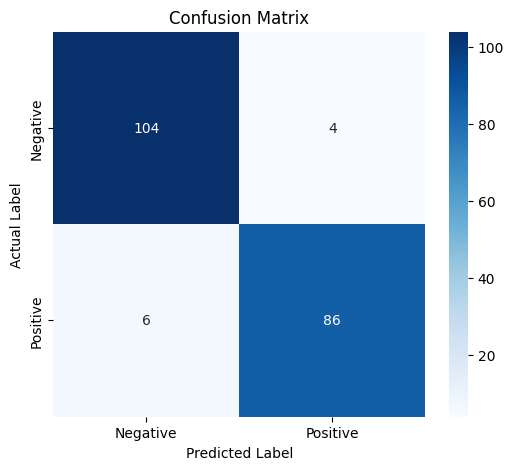

In [7]:
# --- 6. EVALUATION & INSIGHTS ---

print("Evaluating on Validation Set...")
results = trainer.evaluate()
print(f"Validation Accuracy: {results['eval_accuracy']:.4f}")

# Generate Predictions
predictions = trainer.predict(tokenized_val)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Confusion Matrix Visualization
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# --- 7. SAVING & INFERENCE ---

# Save the final model
model_path = "./final_sentiment_bert"
trainer.save_model(model_path)
print(f"Model saved to {model_path}")

# Inference Function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return "POSITIVE" if predicted_class_id == 1 else "NEGATIVE"

# Test with new examples
examples = [
    "The product quality is amazing, I use it every day!",
    "Waste of money, it broke after two days.",
    "Shipping was fast but the item is just okay."
]

print("\n--- LIVE DEMO ---")
for ex in examples:
    sentiment = predict_sentiment(ex)
    print(f"Review: '{ex}'\nSentiment: {sentiment}\n")

Model saved to ./final_sentiment_bert

--- LIVE DEMO ---
Review: 'The product quality is amazing, I use it every day!'
Sentiment: POSITIVE

Review: 'Waste of money, it broke after two days.'
Sentiment: NEGATIVE

Review: 'Shipping was fast but the item is just okay.'
Sentiment: NEGATIVE

